# Интерпритация и анализ AB тестирования

In [134]:
import pandas as pd
import numpy as np
import statistics
from scipy.stats import stats, norm, binom, beta, normaltest, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

### Шаг 1: Знакомство с собранными данными по группам и базовая статистика.

In [135]:
# Dataset with AB testing results (2 groups -> control and treatment)
data = pd.read_csv('./datasets/cookie_cats.csv', index_col=False)
data.head(4)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False


In [136]:
# check the features and data types of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [137]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [138]:
# Check if there is a corrupt or empty observations
data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [139]:
# What kind of groups do we have in A/B testing
data.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [140]:
# Distribution by groups
data.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [141]:
# Distribution by groups in %
data.version.value_counts(normalize=True)

version
gate_40    0.504374
gate_30    0.495626
Name: proportion, dtype: float64

In [142]:
# For simplicity let's rename the groups into A for control and B for treatment variants
data['version'] = np.where(data['version']== 'gate_30', 'A', 'B')

In [143]:
print(len(data.userid.unique()),'rows of users data were collected.')

90189 rows of users data were collected.


In [144]:
if len(data[data['version'] == 'A']) + len(data[data['version'] == 'B']) == len(data.userid.unique()):
  print("Each user is test with one version!")
  print(len(data[data['version'] == 'A']),'users were in gate 30.')
  print(len(data[data['version'] == 'B']),'users were in gate 40.' )
else:
  print("There are user are test with more than one version")

Each user is test with one version!
44700 users were in gate 30.
45489 users were in gate 40.


### Предобработка данных для анализа (Data Preprocessing and Data Cleaning)

Что необходимо предпринять:

1. Найти выбросы в данных. Графически исследовать их (вдруг не выбросы).
2. В случае если присутствуют экстремальные значения, то мы избавимся от них (условием для выброса будет = 0 and > 3000).


При работе с датасетом не забываем включать обычную человеческую логику, так как ни одна модель машинного обучения вам с этим не поможет. У нас датасет - это результат АБ тестирования в игровой индустрии. По логике вещей мусорными данными также будут являться данные пользователей, которые не сыграли ни одного раза за всю историю их действий, то есть количество игр по признаку `sum_gamerounds` будет равно 0. Удалим таким пользователей в процесссе обработки датасета, так как они будут вносить ошибку в наш анализ.

Второй момент - это поиск дубликатов пользователей, есть ли пользователи с одинаковым `userid` в обоих тестируемых группах. При обнаружении таких данных, лучше всего также их удалить, чтобы они не вносили статистическую погрешность в наш анализ и интерпритацию результатов.

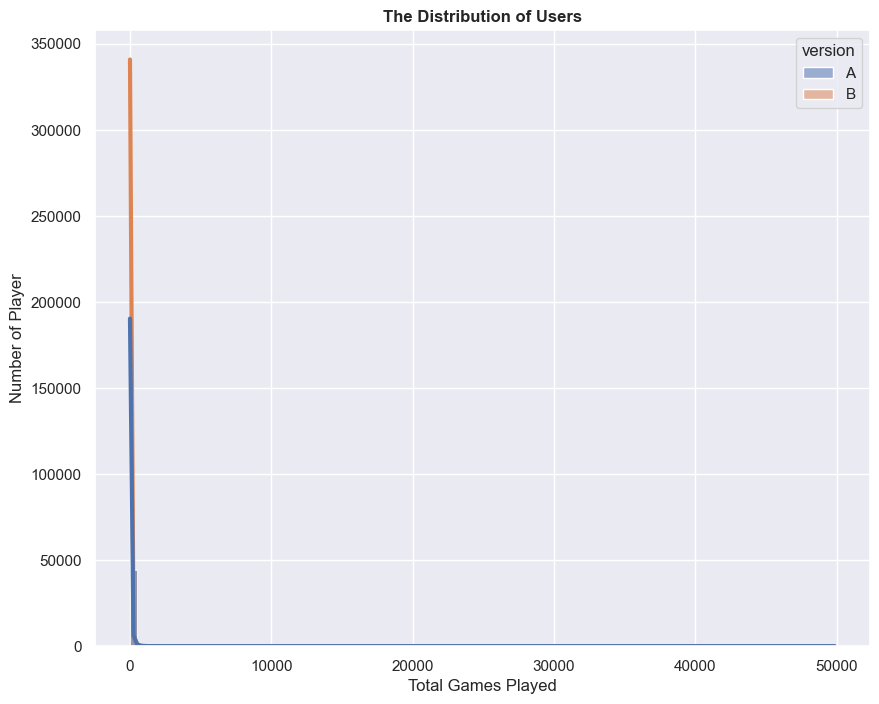

In [145]:
#using histgram to visualize any outliers
sns.set(rc={'figure.figsize':(10,8)})
sns.histplot(data=data, x="sum_gamerounds", kde=True, hue="version", line_kws={"lw":3}, bins=100)
plt.title("The Distribution of Users", fontweight="bold")
plt.xlabel("Total Games Played")
plt.ylabel("Number of Player")
plt.show();

In [146]:
# dealling with users who played 0 rounds of game
print('There are', data[data['sum_gamerounds']==0].shape[0],'users who did not play the game at all.')
data = data[data['sum_gamerounds']!=0].reset_index()

There are 3994 users who did not play the game at all.


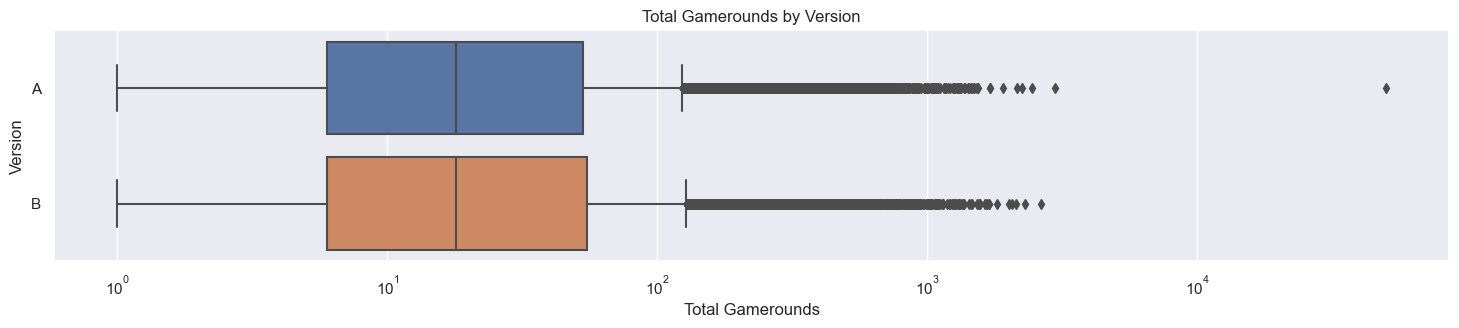

In [147]:
# dealling with outliers
sns.set(rc={'figure.figsize':(18,3)})
ax=sns.boxplot(y = data.version, x = data.sum_gamerounds)
ax.set_xscale('log')
plt.title("Total Gamerounds by Version")
plt.xlabel("Total Gamerounds")
plt.ylabel("Version")
plt.show()

Таким образом мы видим, что присутствуют экстремальные значения в нашем распределении, **удалим то, что принимает значения выше чем 3000 раундов** (возможно просто супер пользователи, которые и так будут играть в нашу игру не смотря на маленькие изменения в структуре приложения, но будьте внимательны если A/B тест направлен на эксперимент именно с такими пользователями, то нам нужно будет исходить от обратного).

In [148]:
data = data[data['sum_gamerounds']<3000].reset_index()

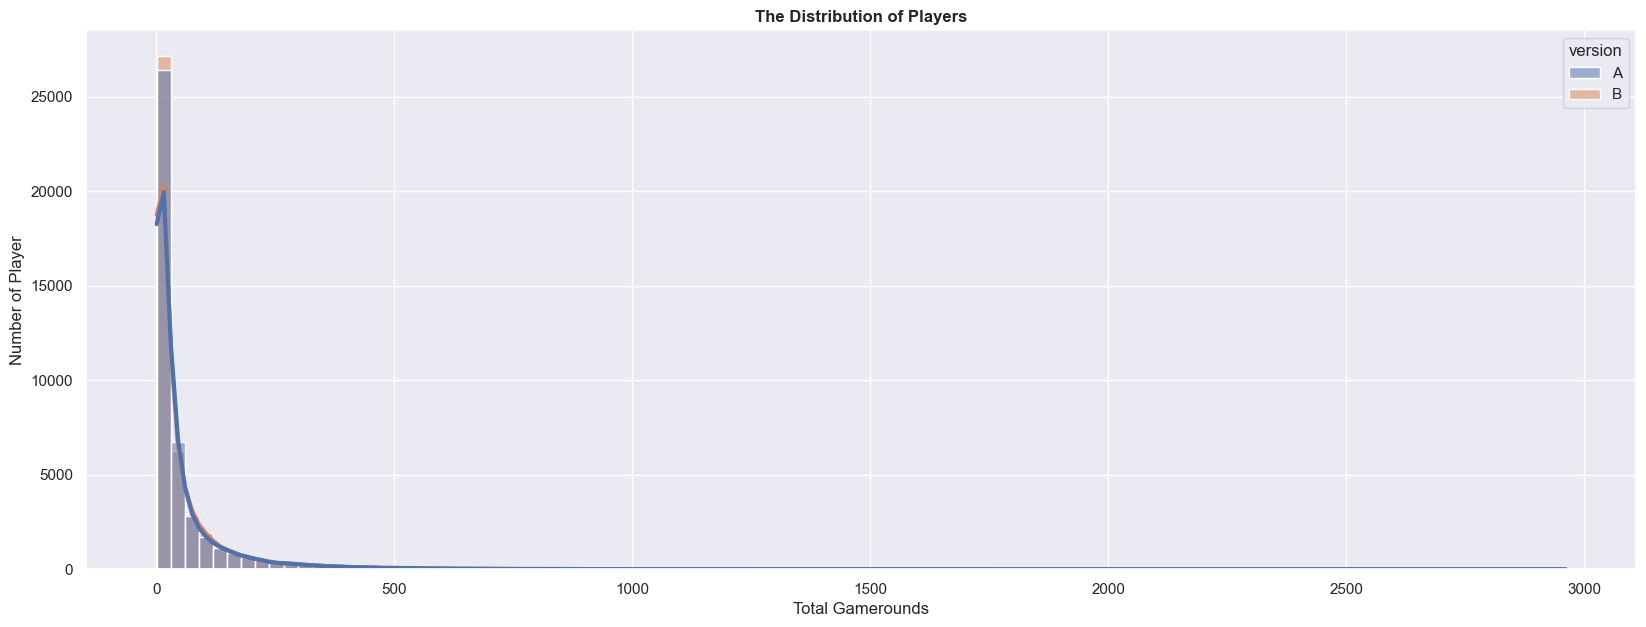

In [149]:
# visualization after remove outliers
sns.set(rc={'figure.figsize':(20,7)})
sns.histplot(data=data, x="sum_gamerounds", kde=True,hue="version",line_kws={"lw":3},bins=100)
plt.title("The Distribution of Players", fontweight="bold")
plt.xlabel("Total Gamerounds")
plt.ylabel("Number of Player")
plt.show()

In [150]:
data.sum_gamerounds.describe()

count    86194.000000
mean        53.698297
std        104.425174
min          1.000000
25%          6.000000
50%         18.000000
75%         54.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

In [151]:
summary = data.groupby('version').sum_gamerounds.agg(['sum','mean','median','max','min'])
summary

,sum,mean,median,max,min
version,,,,,
A,2294941,53.667766,18.0,2961,1
B,2333530,53.728357,18.0,2640,1


In [152]:
(summary['sum'][1]-summary['sum'][0])/summary['sum'][0]*100

1.6814811361163533

#### **Вывод:**

- Всего 90189 уникальных значений для каждого пользователя в данном эксперименте.

<br>

- 44700 пользователей распределенны в группу А и 45489 в группу В.

<br>

- Были найдены и зафиксированы выбросы данных - убрали пользователей в истории которых не было сыгранно ни одного раунда и убрали тех пользователей которые сыграли больше чем 3000 раундов в игре.

<br>

- Относительное количество тестируемых в группе В немного выше чем в группе А на **1.68%**

<br>

- Среднее количество сыгранных раундов в игре составляет **53** для групп А и В.

<br>

- Медианное значение сыгранных раундов в игре составляет **18** для групп А и В.


### Шаг 2: A/B Testing. Анализ и вывод результатов анализа.

#### Statistical Assumptions

Для того, чтобы провести статистическое тестирование, нам необходимо проделать следующие щаги:
1. Выбрать способ тестирования (параметрический тест либо непараметрический тест).
2. Обосновать нулевую и альтернативную гипотезы.
3. Используя Р-значение и Тест Статистику сделать вывод в пользу нулевой гипотезы либо против.


-----

Что необходимо доказать в первую очередь

**1. Независимость**

**2. Нормальность данных**

**3. Гомогенность дисперсии**


----

(Если мы проходим и подтверждаем все 3 пункта выше, то будем пользоваться **параметрическим** подходом к оценке статистического теста, если нет то **непараметрическим**)


##### а) Проверим нормальность графически

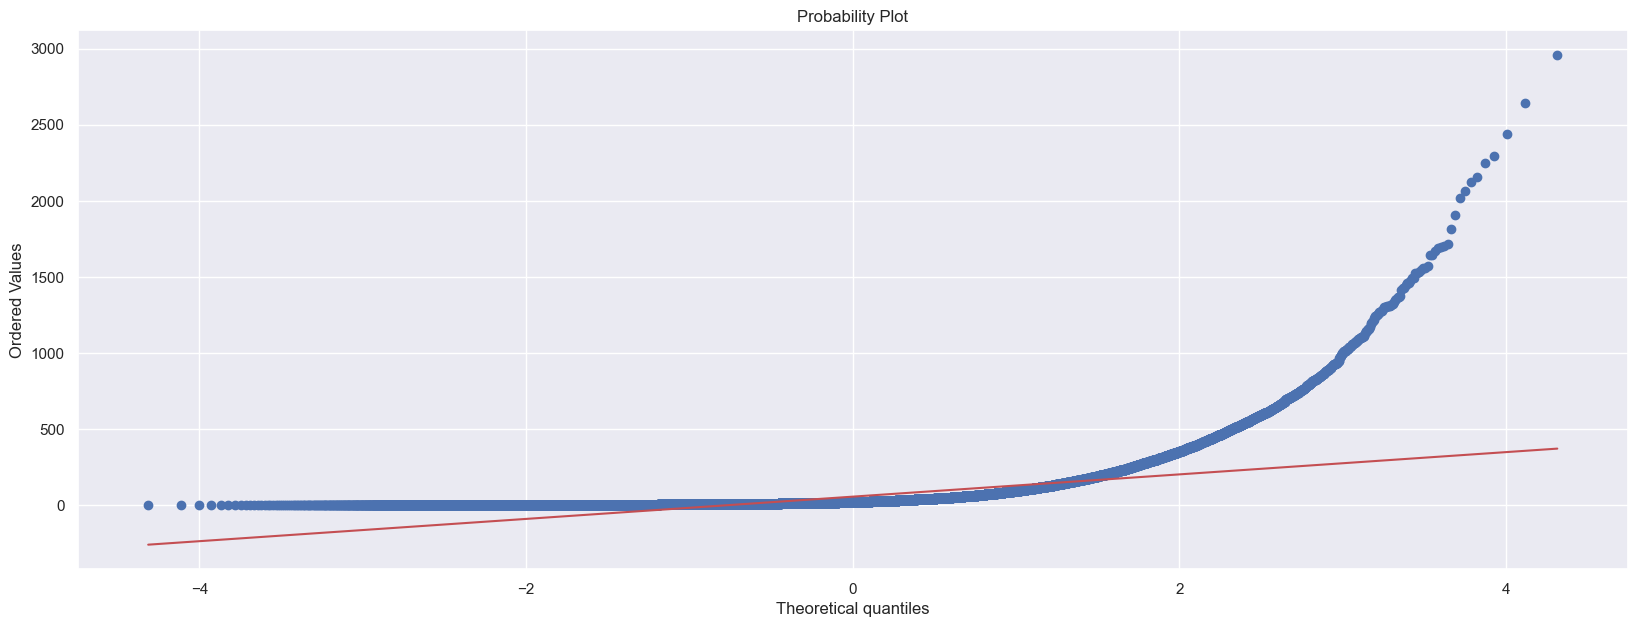

In [153]:
# 1. QQ Plot
# If our data comes from a normal distribution, we should see all the points sitting on the straight line.
import pylab
probplot(data.sum_gamerounds, dist='norm', plot=pylab)
pylab.show()

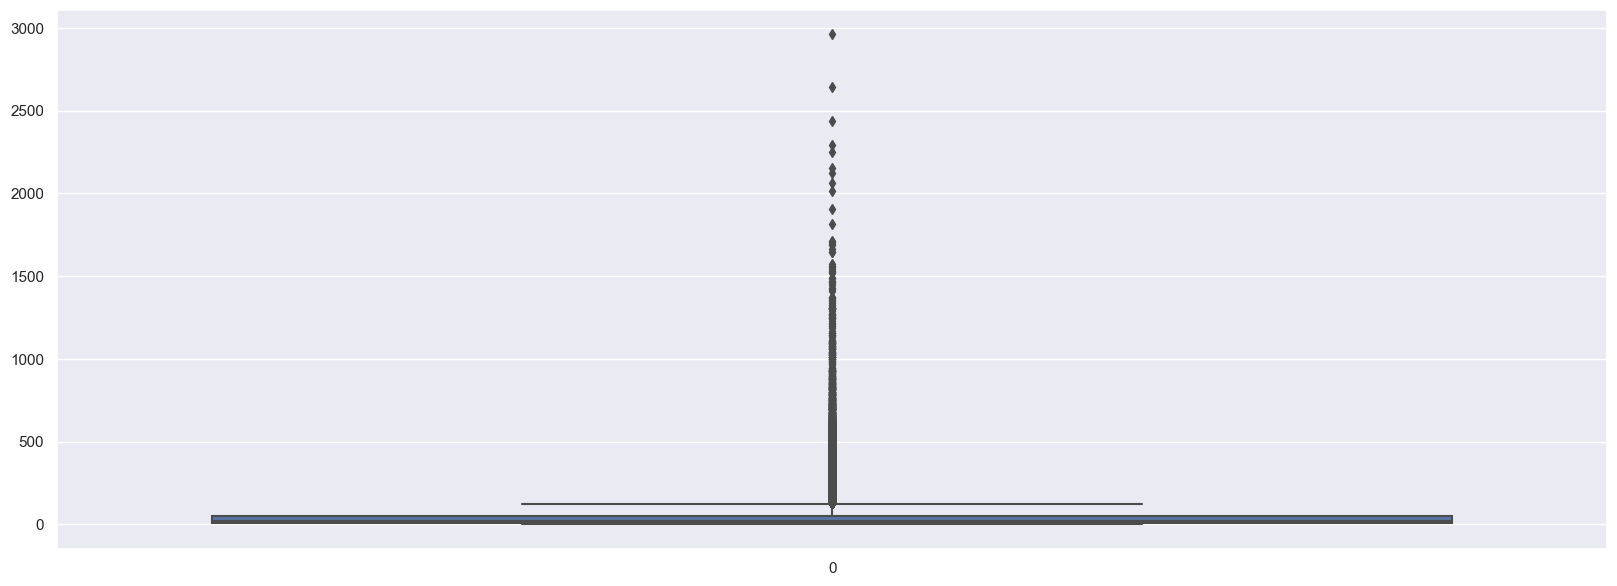

In [154]:
# 2. Box Plot
# If your variable has a normal distribution, we should see the mean and median in the center.
ax = sns.boxplot(data.sum_gamerounds)

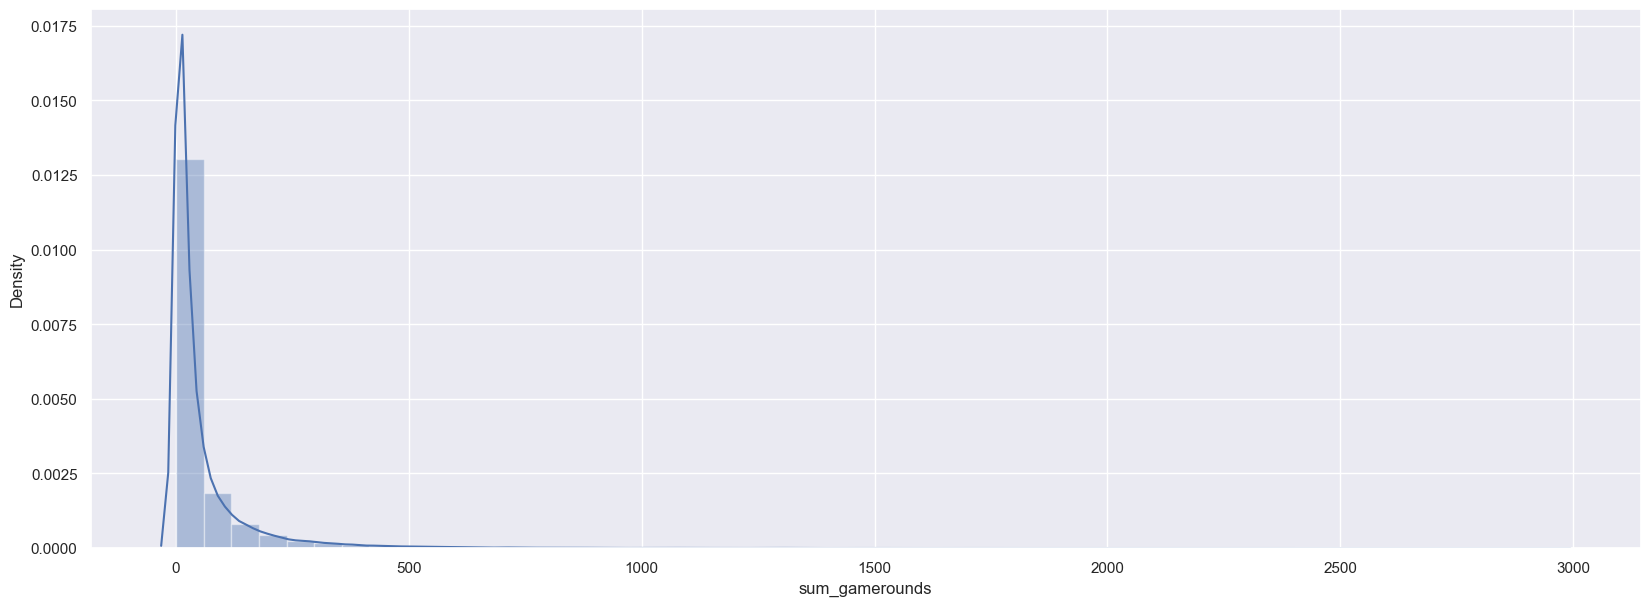

In [155]:
# 3. Histogram
#If your variable has a normal distribution, we should see a bell curve.
sns.distplot(data.sum_gamerounds);

##### б) Проверим нормальность при помощи статистических тестов


Существует множество статистических тестов, которые позволяют выявить нормальность данных. Наиболее популярные из них следующие, вы можете ознакомится с ними по предоставленным ссылкам:

1. [Shapiro-Wilk test for normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
2. [DÁgostino's K-Squared test for normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)
3. [Chi-Square test for normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html)
4. [Kolmogorov-Smirnov test for normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)
5. [Anderson-Darling test for normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)

In [156]:
# 1. Shapiro- Wilk Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.
from scipy.stats import shapiro

def Shapiro_wilk(data):
  stat, p = shapiro(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p > 0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

Shapiro_wilk(data.sum_gamerounds)

Stat = 0.492, p = 0.000

Probably Not Gaussian



In [157]:
# 2.  D’Agostino’s K-squared Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.
from scipy.stats import normaltest

def k_squared(data):
  stat, p = normaltest(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

k_squared(data.sum_gamerounds)

Stat = 98529.876, p = 0.000

Probably Not Gaussian



In [158]:
# 3.  Anderson-Darling Normality Test
#It gives a range of critical values, at which the null hypothesis can be failed to rejected if the calculated statistic is less than the critical value.

from scipy.stats import anderson

def anderson_test(data):
  result = anderson(data)
  print('Stat = %.3f\n' %(result.statistic))
  for i in range(len(result.critical_values)):
    sig_lev, crit_val = result.significance_level[i], result.critical_values[i]
    if result.statistic < crit_val:
      print(f"Probably Gaussian: {crit_val} critical value at {sig_lev} significance level")
    else:
      print(f"Probably Not Gaussian: {crit_val} critical value at {sig_lev} significance level")

anderson_test(data.sum_gamerounds)

Stat = 12556.470

Probably Not Gaussian: 0.576 critical value at 15.0 significance level
Probably Not Gaussian: 0.656 critical value at 10.0 significance level
Probably Not Gaussian: 0.787 critical value at 5.0 significance level
Probably Not Gaussian: 0.918 critical value at 2.5 significance level
Probably Not Gaussian: 1.092 critical value at 1.0 significance level


In [159]:
# 4. Chi-Square Normality Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import chisquare

def chisquare_test(data):
  stat, p = chisquare(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

chisquare_test(data.sum_gamerounds)

Stat = 17503379.103, p = 0.000

Probably Not Gaussian



In [160]:
# 6.   Jarque–Bera Normality Test
# only works for > 2000
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import jarque_bera

def jarque_bera_test(data):
  stat, p = jarque_bera(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

jarque_bera_test(data.sum_gamerounds)

Stat = 14855626.496, p = 0.000

Probably Not Gaussian



In [161]:
# 6. Kolmogorov-Smirnov Normality Test
# on 1 or 2 samples (goodness of fit)
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import kstest

def k_stest(data):
  stat, p = kstest(data,'norm')
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

k_stest(data.sum_gamerounds)

Stat = 0.913, p = 0.000

Probably Not Gaussian



#### Непараметрические тесты



##### Вероятностное сэмплирование

----

В непараметрических тестах мы пытаемся сравнить выборочную среднюю или выборочную медиану (статистику) с версиями А и В в нашем статистическом тесте. Наиболее популярные методы в данном случае - это **`Bootstrapping (Бутстрап) и Boostrap Quantile (Квантиль-Бутстрап) методы`**

- **Bootstrapping** статистическая процедура по сэмплированию датасета (достаем из выборки часть наблюдений, считаем статистику например среднюю, кладем обратно и повторяем до тех пор пока не наберем распределение выборочной статистики).
-**Boostrap Quantile** квантильная оценка по наборам квантилей взятых из выборочного распределения случайным образом

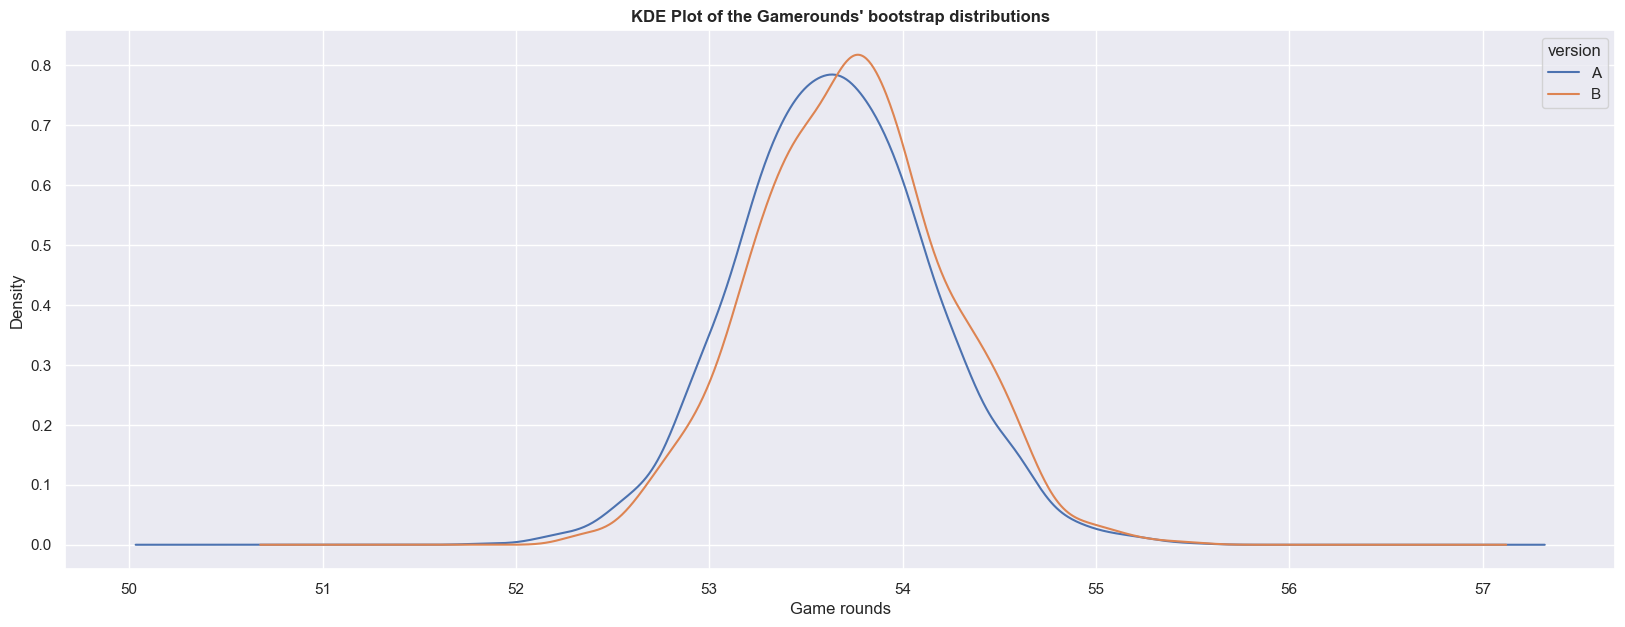

In [162]:
# boostrapping for resample
n = 2000     #number of samples

bootstrap_sum = pd.DataFrame([data.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean() for i in range(n)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Gamerounds' bootstrap distributions", fontweight="bold")
plt.xlabel("Game rounds")
plt.show()

In [165]:
#If the p-value is larger than the chosen significance level then we can state that we can’t reject the null.
#Hence, there is not enough evidence to state that there is a statistically significant difference in Control and Experimental sample means.
bootstrap_sum['diff_mean'] = bootstrap_sum['B'] - bootstrap_sum['A']
mean_pos_count = len(bootstrap_sum[bootstrap_sum['diff_mean'] > 0])
p_mean_diff = mean_pos_count/n
p_mean_diff

0.5495

In [166]:
alpha = 0.05
z_mean = np.mean(bootstrap_sum['B'])- np.mean(bootstrap_sum['A'])
z_sigma = np.sqrt((np.var(bootstrap_sum['B'])/n + np.var(bootstrap_sum['A'])/n))
print("Mean of (verison B - verison A):\t\t\t", z_mean)
print("Standard Error of (verison B -  verison A):\t", z_sigma)
print("CI of (verison B - verison A):\t\t\t\t", [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma] )

Mean of (verison B - verison A):			 0.08011051678521852
Standard Error of (verison B -  verison A):	 0.015785444063357877
CI of (verison B - verison A):				 [0.04917161494106548, 0.11104941862937157]


In [167]:
CI = np.percentile(bootstrap_sum['diff_mean'], [2.5, 97.5])
CI

array([-1.26649602,  1.42439152])

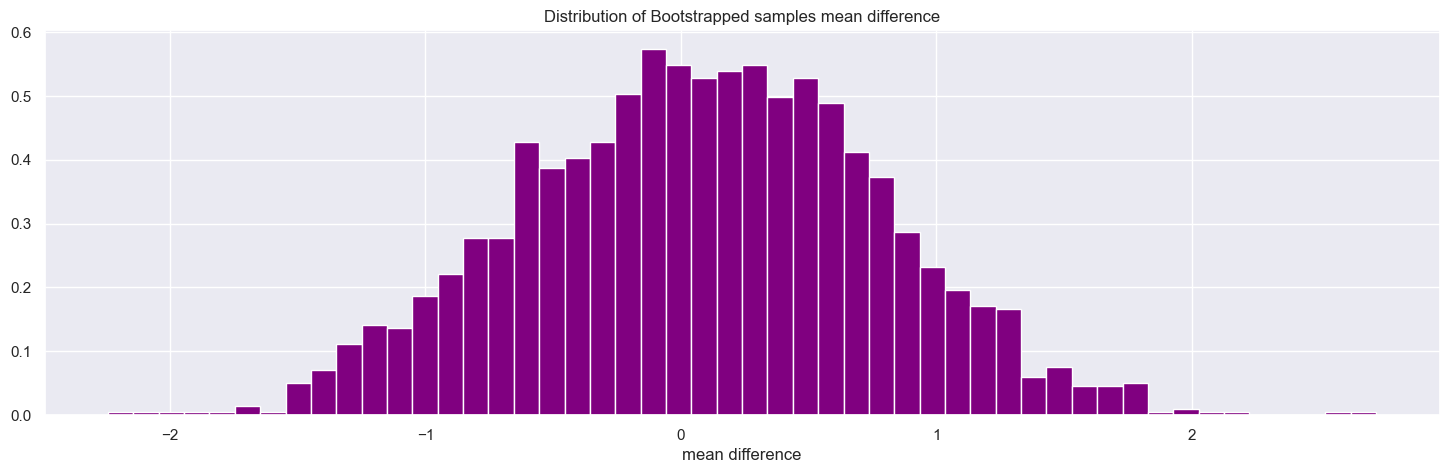

In [168]:
counts,bins,ignored = plt.hist(bootstrap_sum['diff_mean'],50,density = True,color = 'purple')
plt.xlabel("mean difference")
plt.title("Distribution of Bootstrapped samples mean difference")
plt.show()

##### Mann-Whitney U Test

**Параметрические тесты**  используются тогда и только тогда, когда у нас нормальное (либо близко к нормальному) распределение данных:

- t-test
- ANOVA


**Непараметрические тесты** используются тогда и только тогда, когда непрерывные данные ненормально распределенны или когда данные являются дискретными.

- **chi-squared**
- **Fisher’s exact tests**

- **Mann–Whitney U-test**

**H0 (Null hypothesis)** : Нет статистически значимой разницы в признаках sum_gamerounds в 2-х распределениях

**H1 (Alternative hypothesis)**:  Существует статистически значимая разница в признаках sum_gamerounds в 2-х распределениях

In [169]:
from scipy.stats import mannwhitneyu

sum_gamerounds_A = data[data.version=='A'].sum_gamerounds
sum_gamerounds_B = data[data.version=='B'].sum_gamerounds

def mannwhitneyfunc(value1,value2):
    stat, p=mannwhitneyu(value1,value2)
    alpha=0.05

    print('p=%.4f , alpha=%.2f \n'%(p,alpha))
    if p > alpha:
        print('Fail to reject H0; Two version have no significant difference')
    else:
        print('Have enough envidence to reject H0; Two version have a significant difference')

mannwhitneyfunc(sum_gamerounds_A,sum_gamerounds_B)

p=0.1177 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


#### **Вывод:**

- Таким образом статистический анализ признака sum_gamerounds показал, что статистически значимые результаты отсутствуют в двух вариантах теста и нулевую гипотезу по данному признаку отклонить нельзя.

#### 3. Retention. Проведение анализа по другой метрике продукта.

In [171]:
# what is the overall first day retention rate?
data.retention_1.sum()/data.retention_1.count()*100

46.48351393368448

In [172]:
# what is the first day retention rate for each version?
data.groupby('version').retention_1.sum()/data.groupby('version').retention_1.count()*100

version
A    46.754127
B    46.217075
Name: retention_1, dtype: float64

In [173]:
# what is the overall 7th day retention rate?
data.retention_7.sum()/data.retention_7.count()*100

19.434067336473536

In [174]:
# what is the 7th day retention rate for each version?
data.groupby('version').retention_7.sum()/data.groupby('version').retention_7.count()*100

version
A    19.842383
B    19.032050
Name: retention_7, dtype: float64

In [175]:
# How much does the retention drop from first day to 7th day?
(data.groupby('version').retention_1.sum() - data.groupby('version').retention_7.sum())/data.groupby('version').retention_1.sum()*100

version
A    57.560146
B    58.820306
dtype: float64

In [176]:
data.groupby('version').agg({'retention_1':'mean','retention_7':'mean'})

,retention_1,retention_7
version,,
A,0.467541,0.198424
B,0.462171,0.190321


Вывод:
- Общий показатель метрики retention-D1 **46.5%**; группа A **46.8%** и группа B **46.2%**
- Общий показатель метрики retention-D7 **19.4%**; группа A **19.8%** и группа B **19.0%**
- У группы А показатели метрик удержания выше чем у группы В.



**chi-2 test**

- Непараметрический тест (data is discrete)
- Высокий показатель N
- Посмотрим существует ли зависимость между 2-мя групами

-------

- Уровень Значимости (Alpha) = 0.5 = вероятность отклонить нулевую гипотезу когда она истина (Type I)

**H0 (Null hypothesis)** : Не существует статистически значимой разницы между метриками в 2-х вариантах теста

P(retention rate of B) - P(retention rate of A) <= 0

**H1 (Alternative hypothesis)**:  Существует статистически значимая разница между 2-мя вариантами

P(retention rate of B) - P(retention rate of A) > 0


In [177]:
# Chi-square test of independence of variables in a contingency table - Pearson's chi-square test or the chi-square test of association
from scipy.stats import chi2_contingency

def chi2_con_test(data):
    chi2, p, dof, ex = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two verisions have no significant difference')
    else:
        print('Two verisions have a significant difference')

In [178]:
day1_cross_table = pd.crosstab(data["version"], data["retention_1"])
day7_cross_table = pd.crosstab(data["version"], data["retention_7"])

day1_cross_table

retention_1,False,True
version,,
A,22769,19993
B,23359,20073


In [179]:
print('Day 1 retention rate\n')
chi2_con_test(day1_cross_table)

print('*'*50)

print('Day 7 retention rate\n')
chi2_con_test(day7_cross_table)

Day 1 retention rate

p=0.1155 , alpha=0.05 
Two verisions have no significant difference
**************************************************
Day 7 retention rate

p=0.0027 , alpha=0.05 
Two verisions have a significant difference


**Вывод:**

- У обоих вариантов нет статистически значимых изменений в метрике Retention-D1
- У обоих вариантов есть статистически значимый изменения в метрик Retention-D7. В варианте В данный показатель ухудшился и оказываемые изменения оказывают негативный эфффект. Необходимо избавиться от изменений и вернуться к прежней версии приложения.
